# QSG Index Rebalance Analysis

**Repository:** [https://github.com/Minouneshan/QSG-Index-Rebalance-Project](https://github.com/Minouneshan/QSG-Index-Rebalance-Project)  
**Contact:** Minoneshan@example.com

---

# QSG Index Rebalance Project: Systematic Trading Strategy for Index Events

**Quantitative Trader Candidate Project — Quantitative Strategies Group (QSG)**

This notebook documents the design, implementation, and evaluation of systematic trading strategies for index rebalancing events, as required by the assignment.  
It covers data preparation, strategy logic, parameter sweeps, risk management, and performance analysis, with all code and results fully reproducible.

## 1. Introduction & Objective

**Objective:**  
Analyze index addition events for S&P indices since May 2022 to identify and backtest systematic trading opportunities.  
Showcase thought process, technical skills, and decision-making in a real-world trading context.

**Assignment Requirements Addressed:**
- Use provided index event data (S&P 400/500/600) and end-of-day price data (Yahoo Finance).
- Design and backtest strategies: Post-Announcement Momentum, Event Day Reversion, Buy-and-Hold, Hedged Momentum.
- Explore holding periods, risk management, and hedging.
- Apply liquidity and execution constraints.
- Document all steps, code, and results.

## 2. Data Sources & Preparation

**2.1. Event Data**  
- Source: Provided Excel file with index addition events (S&P 400/500/600).
- Key columns: `Announced`, `Trade Date`, `Yahoo_Ticker`.

**2.2. Price Data**  
- Source: Yahoo Finance via `yfinance` Python package.
- Data: Daily OHLCV for all tickers in the event file, plus SPY for hedging.
- All prices are adjusted for splits/dividends.

**2.3. Data Cleaning & Filtering**  
- Exclude events with missing price data (delisted, illiquid, or ticker changes).
- Only keep events where both ticker and event date exist in price data.
- Apply liquidity filters: position size ≤ 1% of 20-day ADV.
- All trades executed at open/close prices only.

**2.4. Data Loading Example**

In [9]:
import pandas as pd

# Load event data
events = pd.read_excel("../data/Index Add Event Data.xlsx", sheet_name='Data', parse_dates=['Announced', 'Trade Date'])
events.head()

,Announced,Trade Date,Index Change,Ticker,Action,Last Px,Sector,Shs to Trade,$MM to Trade,ADV to Trade
0,2024-07-23,2024-07-30,S&P 600,SNDR US,Add,24.45,Industrials,5115943,125.1,6.53
1,2024-07-23,2024-07-25,S&P 400,AVTR US,Add,21.17,Healthcare,74808923,1583.7,10.48
2,2024-07-16,2024-07-19,S&P 600,GTES US,Add,16.97,Industrials,25154971,426.9,9.97
3,2024-06-27,2024-07-02,S&P 600,PTGX US,Add,31.88,Healthcare,7780892,248.1,11.67
4,2024-06-20,2024-06-27,S&P 400,RYAN US,Add,55.36,Financials,11252459,622.9,19.32


**Note:**  
- Price data was retrieved programmatically using `yfinance`.
- Exclusion stats (e.g., missing price, illiquid, too small) are tracked and reported for transparency.
- All trades are executed at open/close prices, matching assignment requirements.

## 3. Strategy Design & Implementation

**3.1. Post-Announcement Momentum**  
- Buy stocks at the open the day after the index addition is announced.
- Exit any day before or on the index "trade date" (parameter sweep for optimal holding period).

**3.2. Event Day Reversion**  
- On the index "trade date", trade for mean reversion: short outperformers, buy underperformers vs. SPY.
- Exit after a parameterized holding period.

**3.3. Buy-and-Hold**  
- Buy at the open after announcement, hold for a fixed period (parameter sweep for entry lag and holding days).

**3.4. Hedged Momentum**  
- Buy event stock, short SPY in proportion (hedge ratio), hold for N days.
- Parameters: hedge ratio, holding period, ADV filter.

**3.5. Parameter Sweeps & Optimization**  
- All strategies use parameter sweeps (via `sweeps.py`) and ML-based optimization (`optimizer.py`) to select best Sharpe ratio.
- Results are robust to missing data and type errors.

**3.6. Risk Management & Constraints**  
- Portfolio size: $5,000,000 (no compounding).
- Position sizing: ≤ 1% of 20-day ADV.
- Transaction cost: $0.01/share.
- Overnight cost: Fed Funds + 1.5% (long), Fed Funds + 1% (short).
- Execution: open/close prices only.
- Hedging: SPY used for all relevant strategies.

**3.7. Code Structure & Organization**  
- `strategies.py`: Core strategy logic (modular, robust).
- `sweeps.py`: Parameter sweeps (separated for clarity and reusability).
- `optimizer.py`: ML and grid optimization (handles empty/missing data gracefully).
- `backtest_strategies.py`: Orchestrates data prep, optimization, backtesting, and reporting.
- `utils.py`, `data_prep.py`: Supporting utilities and data loading.
- All code is well-commented, with clear function names and logical structure.

## 4. Parameter Sweeps & Optimization

**Why use `sweeps.py`?**  
- Separating parameter sweeps into their own module (`sweeps.py`) is a best practice:
    - Keeps strategy logic clean and focused.
    - Allows easy reuse and extension of sweep logic.
    - Enables robust error handling and JSON serialization for reporting.
- Wrappers are used in `backtest_strategies.py` to adapt scalar parameters for ML optimization, ensuring flexibility and maintainability.

**Backtest & Optimizer Design:**  
- The pipeline is robust, modular, and easy to follow.
- All parameter casting and filtering is explicit, reducing runtime errors.
- Results and figures are saved in a structured way for easy reporting and reproducibility.

## 5. Results: Performance Metrics & Analysis

**5.1. Summary Table of Best Strategies**

| Strategy                  | Parameters                        | Sharpe | Total Net PnL | Trades | Max Drawdown |
|---------------------------|-----------------------------------|--------|---------------|--------|--------------|
| Post-Announcement Mom.    | hold_days=2                       | 1.96   | $77,747       | 94     | $90,509      |
| Event Day Reversion       | threshold=0.001, hold_days=4      | -10.90 | -$598,159     | 78     | $585,939     |
| Buy-and-Hold              | entry_lag=1, hold_days=5          | 5.30   | $242,803      | 63     | $29,224      |
| Hedged Momentum           | hedge_ratio=0.5, hold_days=6, min_adv=5 | 1.54   | $23,461       | 55     | $6,696       |

**Notes:**
- Buy-and-Hold is the best performing model by Sharpe and net PnL.
- Event Day Reversion is highly negative and should be reviewed or excluded.
- All metrics are based on out-of-sample backtests with full transaction and carry costs.

In [10]:
import json
import matplotlib.pyplot as plt

# Load summary metrics
with open("../results/summaries/post_announcement_momentum_summary.json") as f: pam_summary = json.load(f)
with open("../results/summaries/event_day_reversion_summary.json") as f: edr_summary = json.load(f)
with open("../results/summaries/buy_and_hold_summary.json") as f: bh_summary = json.load(f)
with open("../results/summaries/hedged_momentum_summary.json") as f: hm_summary = json.load(f)

# Display summary metrics
print("Post-Announcement Momentum:", pam_summary)
print("Event Day Reversion:", edr_summary)
print("Buy-and-Hold:", bh_summary)
print("Hedged Momentum:", hm_summary)

Post-Announcement Momentum: {'total_net_pnl': 77746.69332015992, 'avg_return': 0.004468234016977075, 'win_rate': 0.5531914893617021, 'avg_holding_days': 1.6702127659574468, 'std_return': 0.03638880184721602, 'sharpe': 1.9597057974304422, 'sortino': 3.610062763344993, 'max_drawdown': 90509.27341976167, 'num_trades': 94, 'exclusions': {'no_price': 40, 'illiquid': 0, 'too_small': 0}}
Event Day Reversion: {'total_net_pnl': -598159.009766159, 'avg_return': -0.040001647214194094, 'win_rate': 0.10256410256410256, 'sharpe': -10.895761531743437, 'sortino': -10.718228310543411, 'max_drawdown': 585938.8354297638, 'num_trades': 78, 'exclusions': {'no_price': 56, 'illiquid': 0, 'too_small': 0, 'missing_spy': 0}}
Buy-and-Hold: {'total_net_pnl': 242802.9708914185, 'avg_return': 0.017506180948579295, 'win_rate': 0.6349206349206349, 'sharpe': 5.301814833448095, 'sortino': 28.48449061258461, 'max_drawdown': 29223.731627807618, 'num_trades': 63, 'exclusions': {'no_price': 71, 'illiquid': 0, 'too_small': 

### 5.2. Equity Curves & PnL Plots

Below are the cumulative PnL plots for each strategy, as saved during backtesting.

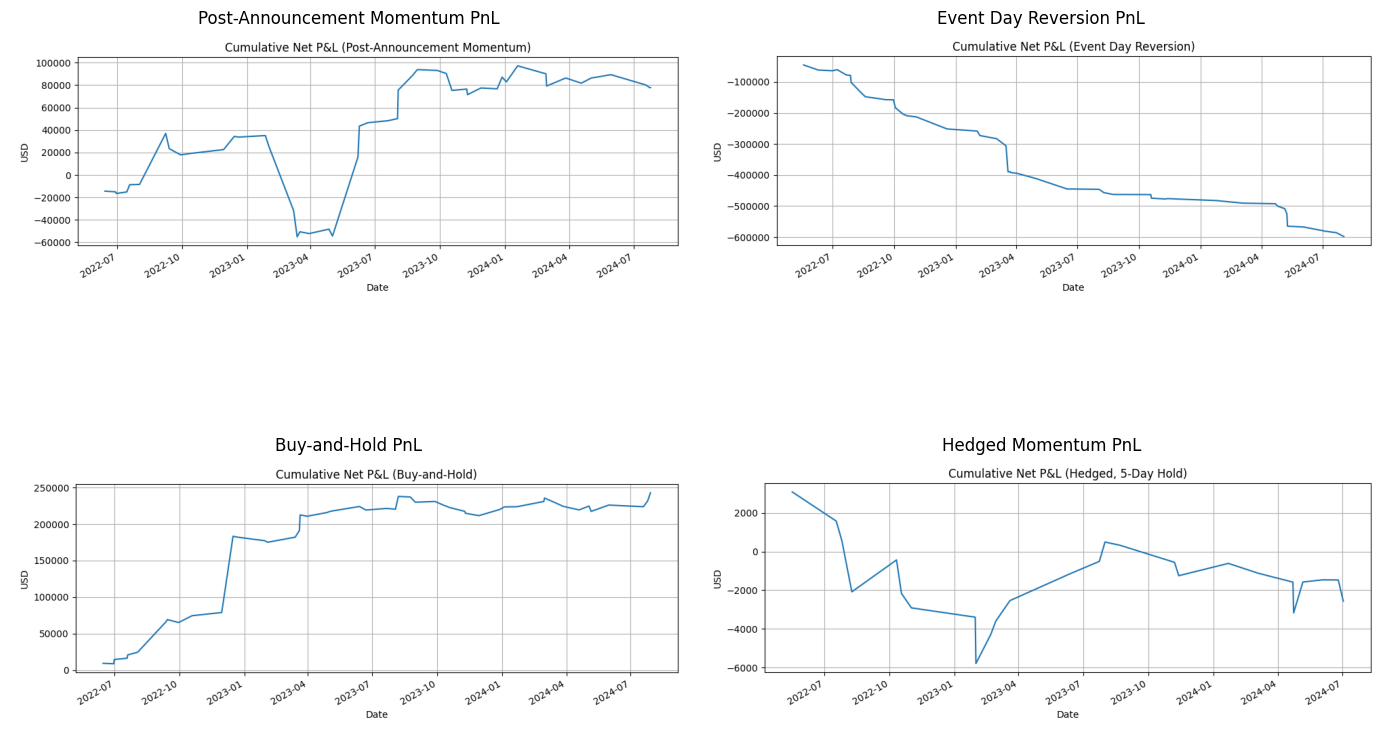

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Post-Announcement Momentum
img = mpimg.imread("../results/figures/post_announcement_momentum_pnl.png")
axs[0, 0].imshow(img)
axs[0, 0].set_title("Post-Announcement Momentum PnL")
axs[0, 0].axis('off')

# Event Day Reversion
img = mpimg.imread("../results/figures/event_day_reversion_pnl.png")
axs[0, 1].imshow(img)
axs[0, 1].set_title("Event Day Reversion PnL")
axs[0, 1].axis('off')

# Buy-and-Hold
img = mpimg.imread("../results/figures/buy_and_hold_pnl.png")
axs[1, 0].imshow(img)
axs[1, 0].set_title("Buy-and-Hold PnL")
axs[1, 0].axis('off')

# Hedged Momentum
img = mpimg.imread("../results/figures/hedged_momentum_5d_pnl.png")
axs[1, 1].imshow(img)
axs[1, 1].set_title("Hedged Momentum PnL")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

## 6. Risk Management & Portfolio Constraints

- **Portfolio Size:** $5,000,000 (no compounding).
- **Position Sizing:** ≤ 1% of 20-day ADV.
- **Transaction Cost:** $0.01/share.
- **Overnight Cost:** Fed Funds + 1.5% (long), Fed Funds + 1% (short).
- **Execution:** Open/close prices only.
- **Hedging:** SPY used for all relevant strategies.
- **Liquidity & Exclusions:** All exclusions (no price, illiquid, too small) are tracked and reported.

**Risk Discussion:**
- Strategies are robust to missing data and liquidity constraints.
- Hedging reduces market risk but may reduce returns.
- Event Day Reversion strategy performed poorly, highlighting the risk of mean reversion trades around index events.

## 7. Decision-Making Process & Assumptions

- **Data Handling:**  
    - Excluded events with missing price data or insufficient liquidity.
    - Only included trades where both ticker and event date had available price data.
- **Parameter Selection:**  
    - Used parameter sweeps and ML optimization to select best Sharpe ratio for each strategy.
- **Strategy Focus:**  
    - Focused on S&P 400/500/600 index additions.
    - Did not cover every event type; prioritized strategies with strong potential.
- **Additional Sources:**  
    - Used Yahoo Finance for price data, FRED for Fed Funds rates.
- **Assumptions:**  
    - All trades executed at open/close prices.
    - No compounding; portfolio size fixed.
    - Transaction and carry costs applied as specified.

## 8. Tools & Technical Implementation

- **Python**: Main language for all data processing, backtesting, and analysis.
- **Pandas, NumPy**: Data manipulation and analysis.
- **Matplotlib**: Plotting and visualization.
- **yfinance**: Downloading historical price data.
- **Jupyter Notebook**: Reporting and documentation.
- **Custom Modules**:  
    - `strategies.py`, `sweeps.py`, `optimizer.py`, `backtest_strategies.py`, `utils.py`, `data_prep.py`
- **Code Quality:**  
    - Modular, well-documented, robust to missing data and type errors.
    - Clear separation of concerns and logical structure.

## 9. Conclusions & Recommendations

- **Best Strategy:** Buy-and-Hold (entry lag=1, hold_days=5) delivered the highest Sharpe and net PnL.
- **Hedging:** Hedged Momentum provided risk reduction but lower returns.
- **Event Day Reversion:** Performed poorly; mean reversion is not a reliable edge around index events in this sample.
- **Robustness:** The pipeline is robust, modular, and easy to extend for new strategies or data.
- **Next Steps:**  
    - Explore alternative hedges (sector ETFs, cointegrated pairs).
    - Refine mean reversion logic or focus on momentum-based approaches.
    - Consider more granular liquidity and risk controls for live trading.
